# Simple Train

This Notebook is written to provide a self-contained overview over the data and network loading and training

It is organized in three parts

1. Creation of a fake dataset with random values
2. Loading this dataset using the Tensorflows [Dataset API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
3. Performing one training step

## Initialize variables and packages

In [4]:
import numpy as np
from S2parser import S2parser
import os
import gzip
import shutil
import tensorflow as tf

parser=S2parser()

# define directory to store the fake dataset
directory="tmp"
if not os.path.exists(directory):
    os.makedirs(directory)

filepaths=["{}/{}.tfrecord.gz".format(directory,i) for i in range(10)]
print(filepaths)

['tmp/0.tfrecord.gz', 'tmp/1.tfrecord.gz', 'tmp/2.tfrecord.gz', 'tmp/3.tfrecord.gz', 'tmp/4.tfrecord.gz', 'tmp/5.tfrecord.gz', 'tmp/6.tfrecord.gz', 'tmp/7.tfrecord.gz', 'tmp/8.tfrecord.gz', 'tmp/9.tfrecord.gz']


## 1. Create a fake random dataset

In [5]:
def write_random_sample(filepath,nobs=46, pix10=24, bands10=4, pix20=12, bands20=6, pix60=6, bands60=3):
    """create a fake sample with random values"""
    x10 = (np.random.random([nobs,pix10,pix10,bands10])*1e4).astype(np.int64)
    x20 = (np.random.random([nobs,pix20,pix20,bands20])*1e4).astype(np.int64)
    x60 = (np.random.random([nobs,pix60,pix60,bands60])*1e4).astype(np.int64)
    doy = (np.random.random([nobs])*365).astype(np.int64)
    year = np.round(np.random.random([nobs])+2016.5).astype(np.int64)
    label = (np.random.random([nobs,pix10,pix10])*17).astype(np.int64)

    # create instance of parser
    parser = S2parser()

    # write .tfrecord
    parser.write(filepath, x10, x20, x60, doy, year, label)

def ziptfrecord(infile,outfile):
    # gzip .tfrecord to .tfrecord.gz
    with open(infile, 'rb') as f_in:
        with gzip.open(outfile, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # remove unzipped .tfrecord
    os.remove(os.path.join(directory, filename))

In [6]:
# create the dataset
for tileid in range(10):
    filename="{}.tfrecord".format(tileid)
    write_random_sample(os.path.join(directory,filename))
    ziptfrecord(os.path.join(directory,filename),os.path.join(directory,filename+".gz"))

    print("writing "+os.path.join(directory,filename+".gz"))

writing tmp/0.tfrecord.gz
writing tmp/1.tfrecord.gz
writing tmp/2.tfrecord.gz
writing tmp/3.tfrecord.gz
writing tmp/4.tfrecord.gz
writing tmp/5.tfrecord.gz
writing tmp/6.tfrecord.gz
writing tmp/7.tfrecord.gz
writing tmp/8.tfrecord.gz
writing tmp/9.tfrecord.gz


## 2. Create a Tensorflow Dataset Iterator

See https://www.tensorflow.org/programmers_guide/datasets for more details

- Essentially includes the data in the processing graph as input nodes.
- These commands set up the processing graph of the input pipeline.
- No data is processed,yet.
- Some errors may remain undetected until data is inferred with sess.run(.)

In [38]:
batchsize=2

print("Reset all previously loaded graphs (in case this or the next cells have been executed twice)")
tf.reset_default_graph()

print("creating dataset object")
dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")

def normalize(serialized_feature):
    """ normalize stored integer values to floats approx. [0,1] """
    x10, x20, x60, doy, year, labels = serialized_feature
    x10 = tf.scalar_mul(1e-4, tf.cast(x10, tf.float32))
    x20 = tf.scalar_mul(1e-4, tf.cast(x20, tf.float32))
    x60 = tf.scalar_mul(1e-4, tf.cast(x60, tf.float32))
    doy = tf.cast(doy, tf.float32) / 365
    year = tf.cast(year, tf.float32) - 2016

    return x10, x20, x60, doy, year, labels

def mapping_function(serialized_feature):
    # read data from .tfrecords
    serialized_feature = parser.parse_example(serialized_feature)
    return normalize(serialized_feature)

print("applying the mapping function on all samples (will read tfrecord file and normalize the values)")
dataset = dataset.map(mapping_function)

print("repeat forever until externally stopped")
dataset = dataset.repeat()

print("combine samples to batches")
dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(int(batchsize)))

print("make iterator")
iterator = dataset.make_initializable_iterator()

Reset all previously loaded graphs (in case this or the next cells have been executed twice)
creating dataset object
applying the mapping function on all samples (will read tfrecord file and normalize the values)
repeat forever until externally stopped
combine samples to batches
make iterator


## 3a. Retrieve one sample

retrieving one sample as numpy array (just for fun)
x10.shape: (2, 46, 24, 24, 4)


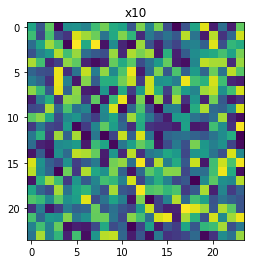

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline


with tf.Session() as sess:
    sess.run(iterator.initializer)
    print("retrieving one sample as numpy array (just for fun)")
    x10, x20, x60, doy, year, labels = sess.run(iterator.get_next())
    print("x10.shape: " + str(x10.shape))
    plt.imshow(x10[0,0,:,:,0])
    plt.title("x10")

# 3b Perform one training step

In [40]:
# define the network to be loaded
# if not yet created, make one with python modelzoo/seqencoder.py script, as described in the readme.md
graph="tmp/convgru128/graph.meta"

with tf.Session() as sess:

    print("loading network graph definition")
    tf.train.import_meta_graph(graph)

    print("initializing variables, tables and the data iterator")
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer(), tf.tables_initializer(),iterator.initializer])

    print("getting one string handle from the iterator that can be fed to the network")
    iterator_handle = sess.run(iterator.string_handle())

    print("making some processing nodes accessible to python")
    def get_operation(name):
        return tf.get_default_graph().get_operation_by_name(name).outputs[0]

    iterator_handle_op = get_operation("data_iterator_handle")
    is_train_op = get_operation("is_train")
    train_op = get_operation("train_op")

    print("performing one training step")
    sess.run(train_op,feed_dict={iterator_handle_op: iterator_handle, is_train_op: True})

loading network graph definition
initializing variables, tables and the data iterator
getting one string handle from the iterator that can be fed to the network
making some processing nodes accessible to python
performing one training step
